# Simulating Poisson typing behavior


## Set up


In [1]:
# Set up to use local modules
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
sys.path.insert(0, module_path)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

## Run simulation

Simulates typing as a poisson process in discrete time, where in each time bin there
is a probability of either typing a correct letter, a wrong letter, or no letter at all.

Error of approximating Poisson as Bernoulli is determined by ratio of time step (dt)
to characters per second (avg_correct_cps)
Error leads to slightly lower wpm than expected, but is negligible for reasonable
values of dt and avg_correct_cps

Incorporrates an error time cost (each error causes a delay in typing, in order to fix it).
Set error_cost=0 to assume no cost to correcting errors.


In [3]:
# Parameters
avg_wpm = 60  # words per minute
word_length = 5  # Standardized word length
avg_acc = 0.95  # fraction of letters typed correctly

dt = 0.001  # time step in seconds
T = 60  # total time in seconds
N = int(T / dt)  # number of time steps
n_trials = 1000  # number of trials

error_cost = 0.0  # cost of making an error (in seconds)

# Dependent parameters
error_cost_dt = round(error_cost / dt)  # cost of making an error (in time steps)
cps_correct = (
    avg_wpm * word_length / 60
)  # correct clicks per second, not including error_cost
cps_incorrect = (
    avg_wpm * word_length / 60 * (1 - avg_acc)
)  # incorrect clicks per second, not including error_cost

cps_total = (cps_correct + cps_incorrect) / (
    1 - (cps_incorrect * error_cost)
)  # Total clicks per second, including error_cost
p_letter = cps_total * dt  # probability of typing a letter in a time step

# Set up arrays
t = np.arange(0, T, dt)  # time array
correct_typed = np.zeros((n_trials, N))  # 1 for correct letter, 0 otherwise
incorrect_typed = np.zeros((n_trials, N))  # 1 for incorrect letter, 0 otherwise

wpm = np.zeros((n_trials))  # Trial wpm
acc = np.zeros((n_trials))  # trial acc

# Loop over trials
for ithTrial in range(n_trials):
    ithTimeStep = 0
    while ithTimeStep < N:
        # Did we type a letter?
        if np.random.rand() < p_letter:
            # Did we type it correctly?
            if np.random.rand() < avg_acc:
                correct_typed[ithTrial, ithTimeStep] = 1
            else:
                incorrect_typed[ithTrial, ithTimeStep] = 1
                ithTimeStep += error_cost_dt  # Jump ahead in time
        ithTimeStep += 1  # Increment time step

    # Calculate words per minute for the trial
    wpm[ithTrial] = np.sum(correct_typed[ithTrial, :]) / word_length / T * 60

    # Calculate accuracy for the trial
    acc[ithTrial] = np.sum(correct_typed[ithTrial, :]) / (
        np.sum(correct_typed[ithTrial, :]) + np.sum(incorrect_typed[ithTrial, :])
    )

## Plot


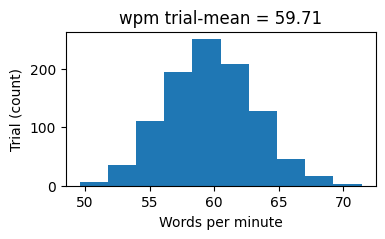

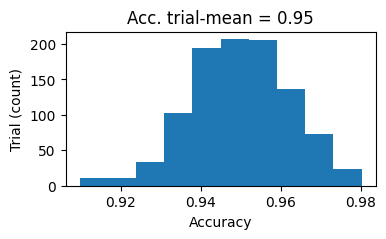

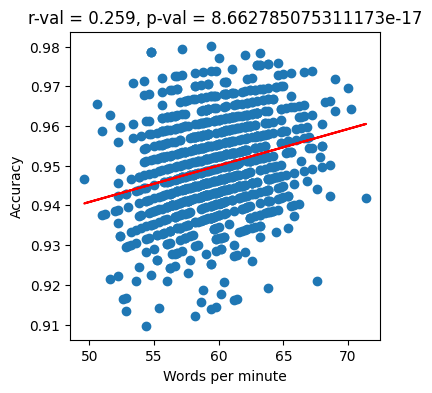

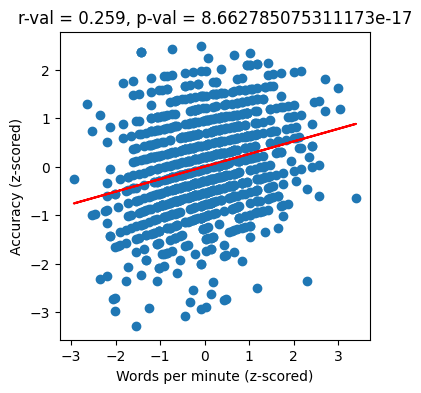

In [4]:
# Plot histograms of wpm and accuracy
plt.figure(figsize=(4, 2))
plt.hist(wpm)
plt.xlabel("Words per minute")
plt.ylabel("Trial (count)")
plt.title("wpm trial-mean = " + str(np.round(np.mean(wpm), 2)))
plt.show()

plt.figure(figsize=(4, 2))
plt.hist(acc)
plt.xlabel("Accuracy")
plt.ylabel("Trial (count)")
plt.title("Acc. trial-mean = " + str(np.round(np.mean(acc), 2)))
plt.show()

# Correlation between wpm and accuracy
wpm_acc_linregres = scipy.stats.linregress(wpm, acc)
plt.figure(figsize=(4, 4))
plt.scatter(wpm, acc)
plt.plot(
    wpm,
    wpm_acc_linregres.intercept + wpm_acc_linregres.slope * wpm,
    "r",
    label="fitted line",
)
plt.xlabel("Words per minute")
plt.ylabel("Accuracy")
plt.title(
    "r-val = "
    + str(np.round(wpm_acc_linregres.rvalue, 4))
    + ", p-val = "
    + str(wpm_acc_linregres.pvalue)
)
plt.show()

# Correlation between wpm and accuracy after z-scoring both
wpm_z = (wpm - np.mean(wpm)) / np.std(wpm)
acc_z = (acc - np.mean(acc)) / np.std(acc)
wpm_z_acc_z_linregres = scipy.stats.linregress(wpm_z, acc_z)
plt.figure(figsize=(4, 4))
plt.scatter(wpm_z, acc_z)
plt.plot(
    wpm_z,
    wpm_z_acc_z_linregres.intercept + wpm_z_acc_z_linregres.slope * wpm_z,
    "r",
    label="fitted line",
)
plt.xlabel("Words per minute (z-scored)")
plt.ylabel("Accuracy (z-scored)")
plt.title(
    "r-val = "
    + str(np.round(wpm_z_acc_z_linregres.rvalue, 4))
    + ", p-val = "
    + str(wpm_z_acc_z_linregres.pvalue)
)
plt.show()